In [1]:
import pandas as pd

In [2]:
df_matches = pd.read_csv('../data/preprocessed/preprocessed_1.csv')

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def train_and_evaluate(train_df, val_df, test_df):
    X_train = train_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_train = train_df["result_match"]

    X_val = val_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_val = val_df["result_match"]

    X_tst = test_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_tst = test_df["result_match"]

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    y_pred = model.predict(X_tst)

    f1 = f1_score(y_tst, y_pred)
    return f1

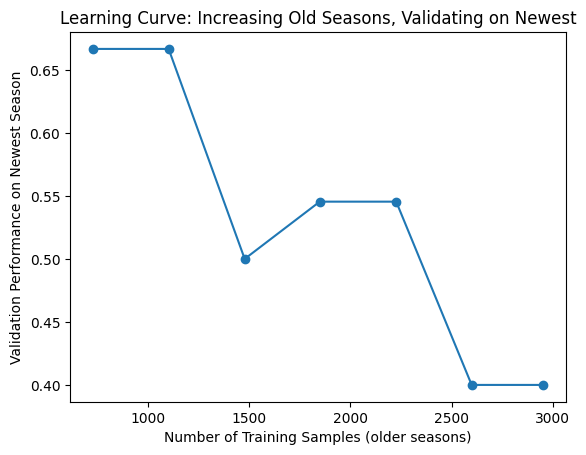

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

sorted_seasons = sorted(df_matches["season"].unique())
newest_season = sorted_seasons[-1]
older_seasons = sorted_seasons[:-1]

max_stage = df_matches.loc[df_matches["season"] == newest_season, "stage"].max()
penultimate_stage = max_stage - 1

train_sizes = []
performances = []

for i in range(1, len(older_seasons) + 1):
    train_seasons = sorted(older_seasons[-i:], reverse=True)

    train_df_older_seasons = df_matches[df_matches["season"].isin(train_seasons)]
    train_df_newest = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]
    train_df = pd.concat([train_df_older_seasons, train_df_newest], ignore_index=True)

    val_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == penultimate_stage)
    ]

    test_df = df_matches[
        (df_matches["season"] == newest_season)
        & (df_matches["stage"] == max_stage)
    ]

    performance_metric = train_and_evaluate(train_df, val_df, test_df)

    train_sizes.append(len(train_df))
    performances.append(performance_metric)

learning_curve_df = pd.DataFrame({
    'train_size': train_sizes,
    'performance': performances
})

plt.plot(learning_curve_df['train_size'], learning_curve_df['performance'], marker='o')
plt.xlabel('Number of Training Samples (older seasons)')
plt.ylabel('Validation Performance on Newest Season')
plt.title('Learning Curve: Increasing Old Seasons, Validating on Newest')
plt.show()

In [5]:
df_matches = df_matches.sort_values(by=["season", "stage", "date"])

older_seasons = sorted(df_matches.season.unique()[-2:], reverse=True)

X_train_old = df_matches[df_matches["season"].isin(older_seasons)]
X_train_new = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] < penultimate_stage)]

df_train = pd.concat([X_train_old, X_train_new], ignore_index=True, )
df_val = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == penultimate_stage)].reset_index(drop=True)
df_tst = df_matches[(df_matches["season"] == newest_season) & (df_matches["stage"] == max_stage)].reset_index(drop=True)

X_trn = df_train.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_trn = df_train["result_match"]

X_val = df_val.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_val = df_val["result_match"]

X_tst = df_tst.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y_tst = df_tst["result_match"]